In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

file_url = 'https://raw.githubusercontent.com/YufanPeter/EPL_Analysis/refs/heads/main/EPL_fyp.csv'

df = pd.read_csv(file_url)

In [2]:
print(df.columns)

Index(['Season', 'Team', 'Venue', 'Result', 'GF (goals for)',
       'GA (goals against)', 'Opponent', 'CrdY', 'CrdR', '2CrdY',
       'Fls (fouls committed)', 'Fld (fouls drawn)', 'Off (offsides)',
       'Crs (crosses)', 'Int (interceptions)', 'TklW (tackles won)',
       'Pkwon (penalty kicks won)', 'Pkcon (penalty kicks conceded)',
       'OG (own goals)', 'Recov (ball recoveries)', 'Won (aerials won)',
       'Lost', 'Won%', 'xG (expected goals)', 'xGA (expected goals allowed)',
       'Poss (possession)', 'First Extra Time', 'First Extra Team Goal',
       'First Extra Opponent Goal', 'Second Extra Time',
       'Second Extra Team Goal', 'Second Extra Opponent Goal', 'Attendance',
       'Referee', 'Referee Hometown', 'Referee Broad Region',
       'Team Detailed Region', 'Team Region', 'Opponent Detailed Region',
       'Opponent Region'],
      dtype='object')


In [3]:
def has_complementary_record(row, df):
    if row['Venue'] == 'Away':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Home')
        ]
    elif row['Venue'] == 'Home':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Away')
        ]
    else:
        return False

    return not match.empty

df['has_match'] = df.apply(lambda row: has_complementary_record(row, df), axis=1)

if df['has_match'].all():
    print("All matched!")
else:
    missing_matches = df[~df['has_match']]
    print("Lack of data")
    print(missing_matches)

All matched!


In [4]:
df_home = df[(df['Venue'] == 'Home') & (df['has_match'])].copy()
df_away = df[(df['Venue'] == 'Away') & (df['has_match'])].copy()

matched_pairs = []
used_away = set()

for home_index, home_row in df_home.iterrows():
    away = df_away[
        (df_away['Season'] == home_row['Season']) &
        (df_away['Team'] == home_row['Opponent']) &
        (df_away['Opponent'] == home_row['Team']) &
        (~df_away.index.isin(used_away))
    ]

    if not away.empty:
        away_index = away.index[0]
        matched_pairs.append((home_index, away_index))
        used_away.add(away_index)

count = 0
for home_idx, away_idx in matched_pairs:
    home_referee = df.loc[home_idx, 'Referee']
    away_referee = df.loc[away_idx, 'Referee']
    if home_referee == away_referee:
        count += 1

print("Number of matched pairs with the same referee:", count)

Number of matched pairs with the same referee: 3800


In [5]:
df['is_win'] = (df['Result'] == 'W').astype(int)

In [6]:
# Here is the analysis of Home advantage
# And I extract all the data of referees officiating Home games and calculate the home win rate and away win rate
# The win rate difference is what I need to analyze whether there is bias
win_df = df.copy()

home_stats = win_df[win_df['Venue'] == 'Home'].groupby('Referee').agg(
    home_games = ('is_win', 'count'),
    home_wins = ('is_win', 'sum')
).reset_index()
home_stats['home_win_rate'] = (home_stats['home_wins'] / home_stats['home_games']).round(2)

away_stats = win_df[win_df['Venue'] == 'Away'].groupby('Referee').agg(
    away_games = ('is_win', 'count'),
    away_wins = ('is_win', 'sum')
).reset_index()
away_stats['away_win_rate'] = (away_stats['away_wins'] / away_stats['away_games']).round(2)

ref_stats = pd.merge(home_stats, away_stats, on='Referee', how='inner')
ref_stats['diff_win_rate'] = ref_stats['home_win_rate'] - ref_stats['away_win_rate']
ref_stats = ref_stats[(ref_stats['home_games'] >= 10) & (ref_stats['away_games'] >= 10)]
ref_stats = ref_stats.sort_values(by='diff_win_rate', ascending=False)

print(ref_stats.head().reset_index(drop=True))

          Referee  home_games  home_wins  home_win_rate  away_games  \
0       Chris Foy          19         11           0.58          19   
1    Tim Robinson          24         14           0.58          24   
2  Thomas Bramall          19          9           0.47          19   
3      Roger East          80         41           0.51          80   
4    Robert Jones          70         37           0.53          70   

   away_wins  away_win_rate  diff_win_rate  
0          3           0.16           0.42  
1          6           0.25           0.33  
2          3           0.16           0.31  
3         18           0.22           0.29  
4         19           0.27           0.26  


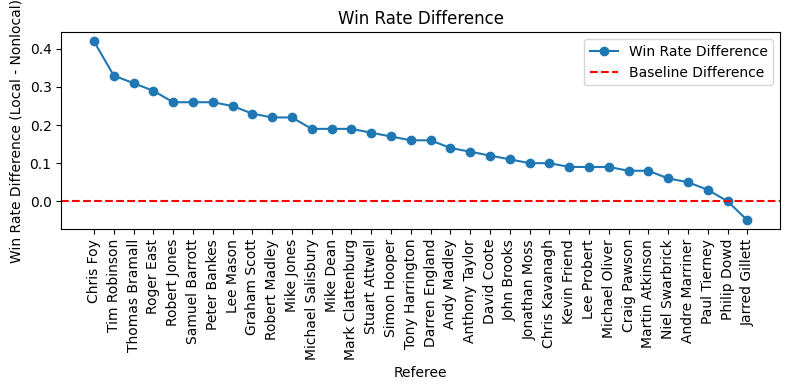

In [7]:
# Through the plot below, it is quite clear before formal analysis, most of the referee have a positive win rate difference
# indicating that home games have a higher win rate when referees are officiating
ref_stats_sorted = ref_stats.sort_values(by='diff_win_rate', ascending=False)

# plt.figure(figsize=(10, 10))
# sns.barplot(x='diff_win_rate', y='Referee', data=ref_stats_sorted, palette='coolwarm', legend=False)
# plt.title("Difference in Win Rate")
# plt.xlabel("Win Rate Difference")
# plt.ylabel("Referee")
# plt.show()

plt.figure(figsize=(8,4))
plt.plot(ref_stats_sorted['Referee'], ref_stats_sorted['diff_win_rate'], marker='o', linestyle='-', label='Win Rate Difference')

plt.axhline(0, color='red', linestyle='--', label='Baseline Difference')
plt.xlabel('Referee')
plt.ylabel('Win Rate Difference (Local - Nonlocal)')
plt.title('Win Rate Difference')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

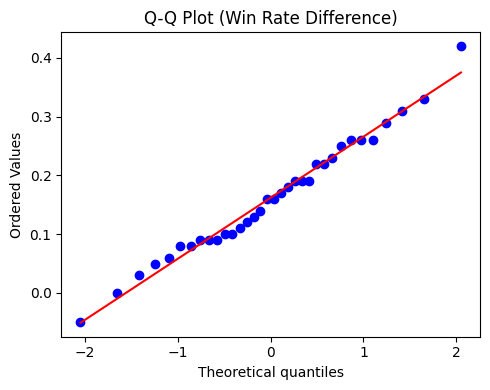

In [8]:
import scipy.stats as stats

win_stats = ref_stats['diff_win_rate'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(win_stats, dist="norm", plot=plt)
plt.title("Q-Q Plot (Win Rate Difference)")
plt.tight_layout()
plt.show()

# stat, p_value = shapiro(ref_stats['diff_win_rate'].dropna())
# print("Shapiro-Wilk test: statistic = {:.3f}, p-value = {:.3f}".format(stat, p_value))

In [9]:
from scipy.stats import shapiro

stat, p = shapiro(win_stats)

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p}")

Shapiro-Wilk Test Statistic: 0.9873670059072754
P-value: 0.9559462840525128


In [10]:
# Implies that there is significant difference in win rate under the condition of home advantage
from scipy.stats import ttest_1samp

t_stat, p_val = ttest_1samp(ref_stats['diff_win_rate'], 0)
print(f"t-test for Diff_xG: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-test for Diff_xG: t-statistic = 9.338, p-value = 0.000


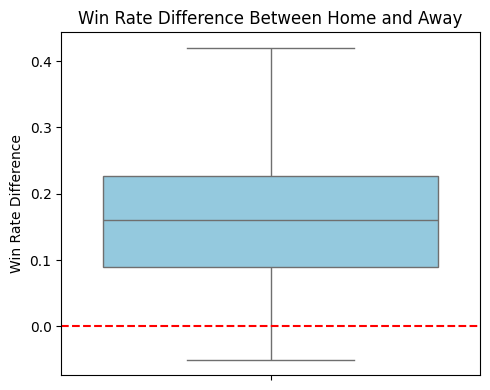

In [11]:
plt.figure(figsize=(5,4))
sns.boxplot(y=ref_stats['diff_win_rate'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Win Rate Difference Between Home and Away")
plt.ylabel("Win Rate Difference")
plt.tight_layout()
plt.show()

In [23]:
# This code computes disciplinary statistics (cards and fouls) for each match,
# comparing home and away teams. It calculates total cards, fouls, and ratios for both sides,
# and derives their differences to analyze referee bias under home advantage.
cards_df = df.copy()

cards_stats =[]

for (home_idx, away_idx) in matched_pairs:
  home_record = cards_df.loc[home_idx]
  away_record = cards_df.loc[away_idx]

  if home_record['Venue'] != 'Home':
    home_record, away_record = away_record, home_record

  referee = home_record['Referee']

  home_cards = home_record['CrdY'] + home_record['2CrdY'] + home_record['CrdR']
  away_cards = away_record['CrdY'] + away_record['2CrdY'] + away_record['CrdR']

  home_fls = home_record['Fls (fouls committed)']
  away_fls = away_record['Fls (fouls committed)']

  home_ratio = (home_fls / home_cards).round(2) if home_cards != 0 else np.nan
  away_ratio = (away_fls / away_cards).round(2) if away_cards != 0 else np.nan

  diff_cards = home_cards - away_cards
  diff_fls = home_fls - away_fls
  diff_ratio = home_ratio - away_ratio

  cards_stats.append({
      'Referee': referee,
      'home_cards': home_cards,
      'away_cards': away_cards,
      'home_fls': home_fls,
      'away_fls': away_fls,
      'home_ratio': home_ratio,
      'away_ratio': away_ratio,
      'diff_cards': diff_cards,
      'diff_fls': diff_fls,
      'diff_ratio': diff_ratio
  })

cards_stats_df = pd.DataFrame(cards_stats)
print(cards_stats_df.head())

          Referee  home_cards  away_cards  home_fls  away_fls  home_ratio  \
0    Robert Jones           1           5        13        11       13.00   
1  Michael Oliver           2           4        12        12        6.00   
2  Anthony Taylor           4           7         5        17        1.25   
3    Robert Jones           6           2         9        11        1.50   
4    Craig Pawson           0           1         8         9         NaN   

   away_ratio  diff_cards  diff_fls  diff_ratio  
0        2.20          -4         2       10.80  
1        3.00          -2         0        3.00  
2        2.43          -3       -12       -1.18  
3        5.50           4        -2       -4.00  
4        9.00          -1        -1         NaN  


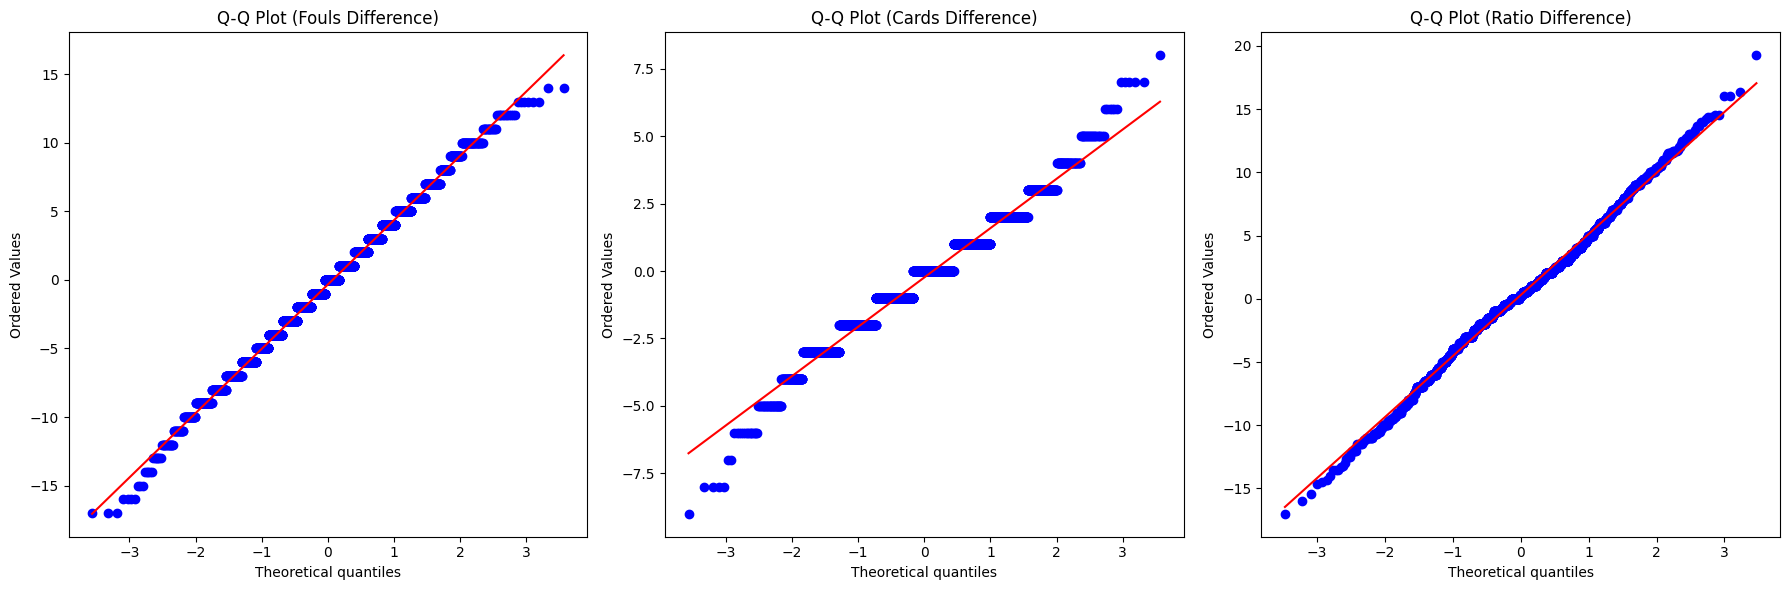

In [24]:
fls = cards_stats_df['diff_fls'].dropna()
crds = cards_stats_df['diff_cards'].dropna()
ratio = cards_stats_df['diff_ratio'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

stats.probplot(fls, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot (Fouls Difference)")

stats.probplot(crds, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot (Cards Difference)")

stats.probplot(ratio, dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot (Ratio Difference)")

plt.tight_layout()
plt.show()

In [25]:
shapiro_fls = shapiro(fls)
shapiro_crds = shapiro(crds)
shapiro_ratio = shapiro(ratio)

print("Shapiro-Wilk Test (Fouls Difference):", shapiro_fls.pvalue)
print("Shapiro-Wilk Test (Cards Difference):", shapiro_crds.pvalue)
print("Shapiro-Wilk Test (Ratio Difference):", shapiro_ratio.pvalue)

Shapiro-Wilk Test (Fouls Difference): 1.865117668036763e-09
Shapiro-Wilk Test (Cards Difference): 7.535664123439218e-28
Shapiro-Wilk Test (Ratio Difference): 3.980763509978399e-08


In [26]:
from scipy.stats import ttest_1samp

t_stat_cards, p_val_cards = ttest_1samp(cards_stats_df['diff_cards'].dropna(), 0)
t_stat_fouls, p_val_fouls = ttest_1samp(cards_stats_df['diff_fls'].dropna(), 0)
t_stat_ratio, p_val_ratio = ttest_1samp(cards_stats_df['diff_ratio'].dropna(), 0)

print(f"t-test for Diff_Cards: t-statistic = {t_stat_cards:.3f}, p-value = {p_val_cards:.3f}")
print(f"t-test for Diff_Fouls: t-statistic = {t_stat_fouls:.3f}, p-value = {p_val_fouls:.3f}")
print(f"t-test for Diff_Ratio: t-statistic = {t_stat_ratio:.3f}, p-value = {p_val_ratio:.3f}")

t-test for Diff_Cards: t-statistic = -7.926, p-value = 0.000
t-test for Diff_Fouls: t-statistic = -4.446, p-value = 0.000
t-test for Diff_Ratio: t-statistic = 3.097, p-value = 0.002


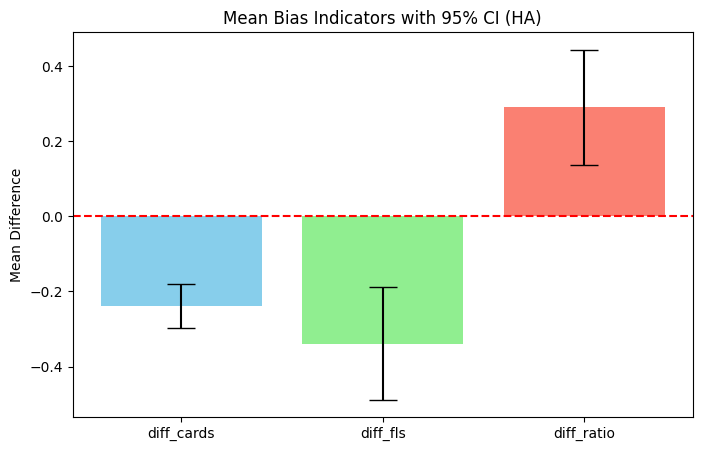

In [33]:
features = ['diff_cards', 'diff_fls', 'diff_ratio']
means = [cards_stats_df[feat].mean() for feat in features]
stds = [cards_stats_df[feat].std() for feat in features]
n = len(cards_stats_df)

cis = [1.96 * std / np.sqrt(n) for std in stds]

plt.figure(figsize=(8, 5))
plt.bar(features, means, yerr=cis, capsize=10, color=['skyblue', 'lightgreen', 'salmon'])
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Mean Difference')
plt.title('Mean Bias Indicators with 95% CI (HA)')
plt.show()

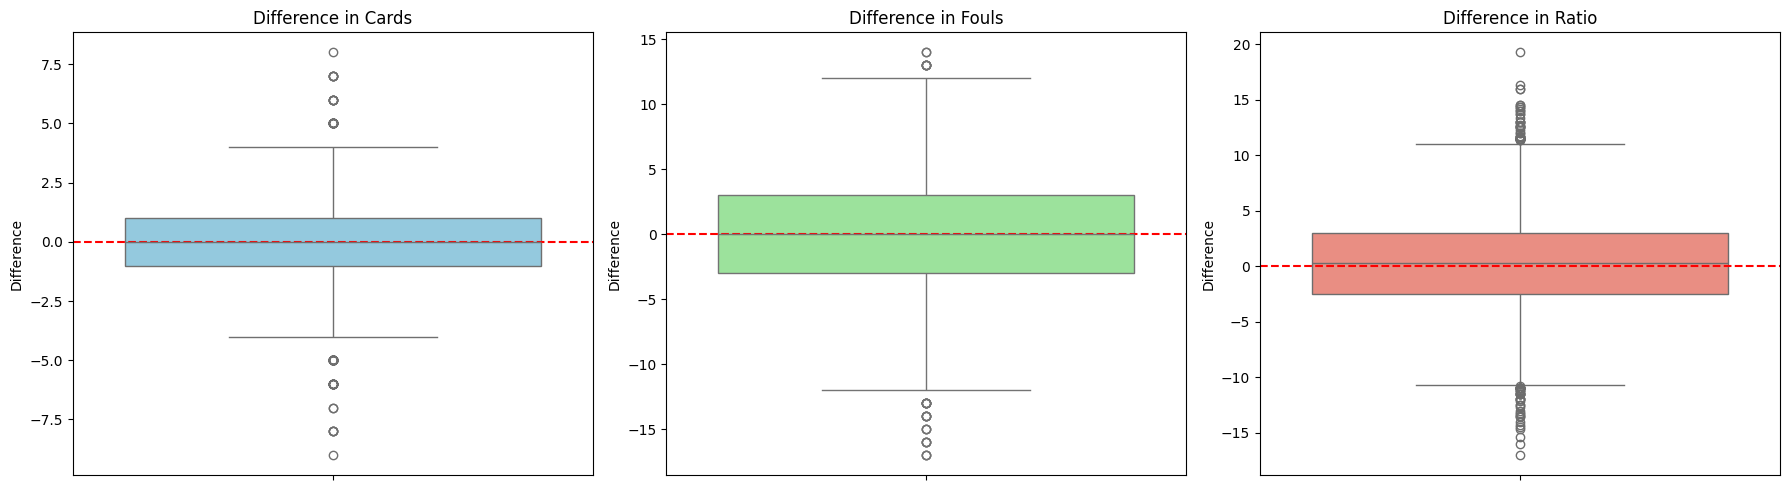

In [34]:
features = ['diff_cards', 'diff_fls', 'diff_ratio']
titles = ['Difference in Cards', 'Difference in Fouls', 'Difference in Ratio']
colors = ['skyblue', 'lightgreen', 'salmon']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    sns.boxplot(
        y=cards_stats_df[feature],
        ax=axes[i],
        color=colors[i],
        showfliers=True
    )
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Difference')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [35]:
# This code aggregates referee-level statistics based on match data.
# It computes the average and standard deviation of cards, fouls, and card-to-foul ratios
# for home and away teams. Only referees with more than 5 matches are kept
referee_agg = cards_stats_df.groupby('Referee').agg(
    total_matches=('Referee', 'count'),
    avg_home_cards=('home_cards', 'mean'),
    avg_away_cards=('away_cards', 'mean'),
    avg_diff_cards=('diff_cards', 'mean'),
    std_diff_cards=('diff_cards', 'std'),
    avg_home_fls=('home_fls', 'mean'),
    avg_away_fls=('away_fls', 'mean'),
    avg_diff_fls=('diff_fls', 'mean'),
    std_diff_fls=('diff_fls', 'std'),
    avg_home_ratio=('home_ratio', 'mean'),
    avg_away_ratio=('away_ratio', 'mean'),
    avg_diff_ratio=('diff_ratio', 'mean'),
    std_diff_ratio=('diff_ratio', 'std')
).reset_index().round(2)

referee_diff = referee_agg[['Referee', 'total_matches', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio']]
referee_diff = referee_diff[referee_diff['total_matches'] > 5]
referee_diff = referee_diff.sort_values(by='avg_diff_ratio', ascending=False)

print(referee_diff.reset_index(drop=True))

              Referee  total_matches  avg_diff_cards  avg_diff_fls  \
0         Darren Bond              9           -0.33          1.67   
1        Tim Robinson             24           -0.75          1.08   
2         Lee Probert             43           -0.33          0.63   
3      Darren England             57           -0.79         -0.46   
4      Samuel Barrott             15           -0.40         -1.47   
5          Mike Jones             74           -0.47         -0.41   
6        Robert Jones             70           -0.44          0.06   
7        Simon Hooper            102           -0.43         -0.19   
8           Chris Foy             19           -0.63          0.05   
9    Mark Clattenburg             79           -0.33          0.19   
10       Peter Bankes             70           -0.81         -0.87   
11         Roger East             80           -0.38         -0.76   
12  Michael Salisbury             32           -0.47          0.09   
13       Craig Pawso

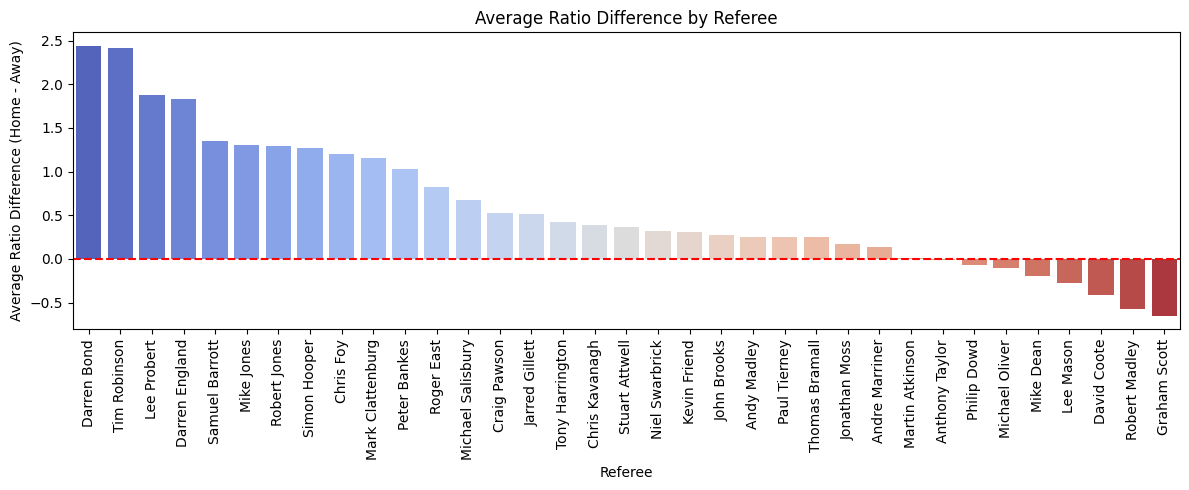

In [36]:
# Here is the average ratio difference of every referee
# The assumption is that if the average ratio difference is positive, referee may have the possibility to give favorable decision to 'Home' teams
plt.figure(figsize=(12,5))
sns.barplot(x='Referee', y='avg_diff_ratio', data=referee_diff, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Average Ratio Difference (Home - Away)")
plt.title("Average Ratio Difference by Referee")
plt.tight_layout()
plt.show()

In [37]:
# Similar to the analysis in referee hometown, here I analyze if home advantage will have impact on referee's decision of extra time
extra_time_df = df.copy()

extra_time_stats = []

for (home_idx, away_idx) in matched_pairs:
  home_record = extra_time_df.loc[home_idx]
  away_record = extra_time_df.loc[away_idx]

  if home_record['Venue'] != 'Home':
    home_record, away_record = away_record, home_record

  referee = home_record['Referee']
  extra_time = home_record['Second Extra Time']
  final_result = home_record['Result']

  home_extra_goal = home_record['Second Extra Team Goal']
  away_extra_goal = away_record['Second Extra Team Goal']
  diff_extra_goal = home_extra_goal - away_extra_goal

  home_regular_goal = home_record['GF (goals for)'] - home_extra_goal
  away_regular_goal = away_record['GF (goals for)'] - away_extra_goal
  diff_regular_goal = home_regular_goal - away_regular_goal

  if diff_regular_goal > 0:
    outcome = 'Leading'
  elif diff_regular_goal == 0:
    outcome = 'Drawing'
  else:
    outcome = 'Trailing'

  if outcome != 'Leading' and final_result == 'W':
    outcome_change = True
  elif outcome == 'Leading' and final_result != 'W':
    outcome_change = True
  else:
    outcome_change = False

  extra_time_stats.append({
        'Referee': referee,
        'Match': (home_record['Team'], away_record['Team']),
        'Regular_Time_Outcome': outcome,
        'Final_Result': final_result,
        'Outcome_Changed': outcome_change,
        'Regular_Goal_Difference': diff_regular_goal,
        'Extra_Time': extra_time,
        'Extra_Goal_Difference': diff_extra_goal
    })

extra_time_df = pd.DataFrame(extra_time_stats)
print(extra_time_df.head())

          Referee                                      Match  \
0    Robert Jones        (Manchester City, Newcastle United)   
1  Michael Oliver                  (Manchester City, Fulham)   
2  Anthony Taylor       (Manchester City, Nottingham Forest)   
3    Robert Jones  (Manchester City, Brighton & Hove Albion)   
4    Craig Pawson             (Manchester City, Bournemouth)   

  Regular_Time_Outcome Final_Result  Outcome_Changed  Regular_Goal_Difference  \
0              Leading            W            False                        1   
1              Leading            W            False                        3   
2              Leading            W            False                        2   
3              Leading            W            False                        1   
4              Leading            W            False                        5   

   Extra_Time  Extra_Goal_Difference  
0           5                      0  
1           7                      1  
2          

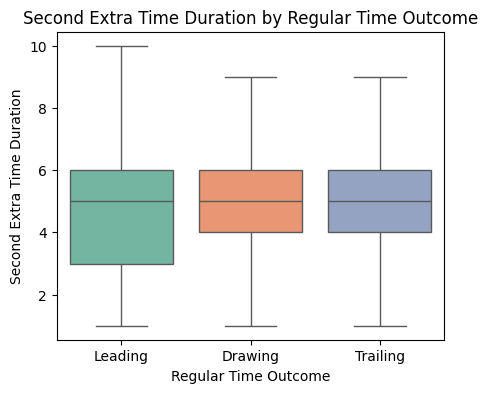

In [38]:
# The outcome is still obvious, the leading group's lower bound is much smaller than drawing and trailing
from scipy.stats import f_oneway, kruskal

plt.figure(figsize=(5,4))
sns.boxplot(x='Regular_Time_Outcome', y='Extra_Time', data=extra_time_df, palette="Set2", showfliers=False)

plt.title("Second Extra Time Duration by Regular Time Outcome")
plt.xlabel("Regular Time Outcome")
plt.ylabel("Second Extra Time Duration")
plt.show()

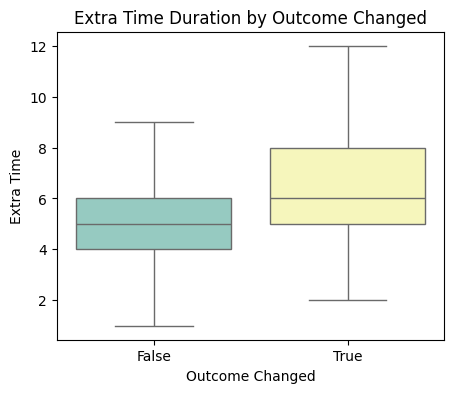

In [39]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Outcome_Changed', y='Extra_Time', data=extra_time_df, palette="Set3", showfliers=False)
plt.title("Extra Time Duration by Outcome Changed")
plt.xlabel("Outcome Changed")
plt.ylabel("Extra Time")
plt.show()

In [40]:
# group_leading = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Leading']['Extra_Time'].dropna()
# group_drawing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Drawing']['Extra_Time'].dropna()
# group_trailing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Trailing']['Extra_Time'].dropna()

# stat_ld, p_ld = stats.mannwhitneyu(group_leading, group_drawing, alternative='two-sided')
# stat_lt, p_lt = stats.mannwhitneyu(group_leading, group_trailing, alternative='two-sided')
# stat_dt, p_dt = stats.mannwhitneyu(group_drawing, group_trailing, alternative='two-sided')

# p_ld_adj = min(p_ld * 3, 1.0)
# p_lt_adj = min(p_lt * 3, 1.0)
# p_dt_adj = min(p_dt * 3, 1.0)

# print("Mann-Whitney U test results:")
# print(f"Leading vs Drawing: stat = {stat_ld:.3f}, raw p = {p_ld:.3f}, adjusted p = {p_ld_adj:.3f}")
# print(f"Leading vs Trailing: stat = {stat_lt:.3f}, raw p = {p_lt:.3f}, adjusted p = {p_lt_adj:.3f}")
# print(f"Drawing vs Trailing: stat = {stat_dt:.3f}, raw p = {p_dt:.3f}, adjusted p = {p_dt_adj:.3f}")

# Here the Kruskal-Wallis test also indicate that at least one pair has significant difference
from scipy.stats import kruskal

group_leading = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Leading']['Extra_Time'].dropna()
group_drawing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Drawing']['Extra_Time'].dropna()
group_trailing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Trailing']['Extra_Time'].dropna()

stat_kruskal, p_kruskal = kruskal(group_leading, group_drawing, group_trailing)

print(f"Kruskal-Wallis test: stat = {stat_kruskal:.3f}, p = {p_kruskal:.3f}")

Kruskal-Wallis test: stat = 21.909, p = 0.000


In [41]:
!pip install scikit_posthocs

In [42]:
# The leading group has statistically significant difference between drawing/trailing group
from scikit_posthocs import posthoc_dunn

p_dunn = (posthoc_dunn([group_leading, group_drawing, group_trailing], p_adjust="holm")).round(2)

print("Dunn's test p-values:")
print(p_dunn)

Dunn's test p-values:
     1     2     3
1  1.0  0.00  0.00
2  0.0  1.00  0.69
3  0.0  0.69  1.00


Optimization terminated successfully.
         Current function value: 0.112013
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:     is_Outcome_Changed   No. Observations:                 3800
Model:                          Logit   Df Residuals:                     3794
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1906
Time:                        14:25:08   Log-Likelihood:                -425.65
converged:                       True   LL-Null:                       -525.85
Covariance Type:            nonrobust   LLR p-value:                 2.325e-41
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.3135      0.275

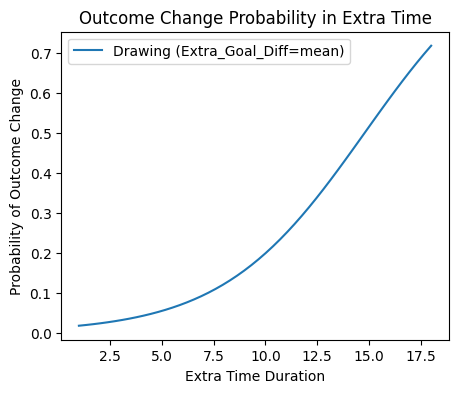

In [43]:
# This logistic regression model shows that longer extra time significantly increases the probability that a match outcome will change, especially when the regular time result is still a draw.
# The model also confirms that scoring during extra time plays a key role.
import statsmodels.formula.api as smf

extra_time_df['is_Outcome_Changed'] = extra_time_df['Outcome_Changed'].astype(int)

model_outcome = smf.logit("is_Outcome_Changed ~ Extra_Time + Extra_Goal_Difference + C(Regular_Time_Outcome) + Extra_Time:Extra_Goal_Difference", data=extra_time_df).fit()
print(model_outcome.summary())

time_range = np.linspace(extra_time_df['Extra_Time'].min(), extra_time_df['Extra_Time'].max(), 50)
df_pred = pd.DataFrame({
    'Extra_Time': time_range,
    'Extra_Goal_Difference': extra_time_df['Extra_Goal_Difference'].mean(),
    'Regular_Time_Outcome': 'Drawing'
})
df_pred['pred_prob'] = model_outcome.predict(df_pred)

plt.figure(figsize=(5,4))
plt.plot(df_pred['Extra_Time'], df_pred['pred_prob'], label="Drawing (Extra_Goal_Diff=mean)")
plt.xlabel("Extra Time Duration")
plt.ylabel("Probability of Outcome Change")
plt.title("Outcome Change Probability in Extra Time")
plt.legend()
plt.show()

In [44]:
# Conduct the data cleaning before analysis, remove rows with empty xG
xg_df = df.copy()

xg_df = xg_df.dropna(subset=['xG (expected goals)'])

clean_matched_pairs = []

for (home_idx, away_idx) in matched_pairs:
    if home_idx in xg_df.index and away_idx in xg_df.index:
        home_xg = xg_df.loc[home_idx]['xG (expected goals)']
        away_xg = xg_df.loc[away_idx]['xG (expected goals)']
        if pd.notnull(home_xg) and pd.notnull(away_xg):
            clean_matched_pairs.append((home_idx, away_idx))

print("Number of matched pairs after cleaning:", len(clean_matched_pairs))

Number of matched pairs after cleaning: 2660


In [45]:
# This code computes expected goals (xG) statistics for home and away teams
# using matched pairs with valid xG data. It calculates the xG difference per match
# and collects the win indicator and referee for further analysis.
xg_stats =[]

for (home_idx, away_idx) in clean_matched_pairs:
  home_record = xg_df.loc[home_idx]
  away_record = xg_df.loc[away_idx]

  if home_record['Venue'] != 'Home':
    home_record, away_record = away_record, home_record

  referee = home_record['Referee']

  home_xg = home_record['xG (expected goals)']
  away_xg = away_record['xG (expected goals)']
  diff_xg = home_xg - away_xg

  xg_stats.append({
      'Referee': referee,
      'home_xg': home_xg,
      'away_xg': away_xg,
      'diff_xg': diff_xg,
      'is_win': home_record['is_win']
  })

xg_stats_df = pd.DataFrame(xg_stats)
print(xg_stats_df.head())

          Referee  home_xg  away_xg  diff_xg  is_win
0    Robert Jones      1.0      0.3      0.7       1
1  Michael Oliver      2.2      1.4      0.8       1
2  Anthony Taylor      1.3      1.0      0.3       1
3    Robert Jones      0.8      0.8      0.0       1
4    Craig Pawson      1.9      0.9      1.0       1


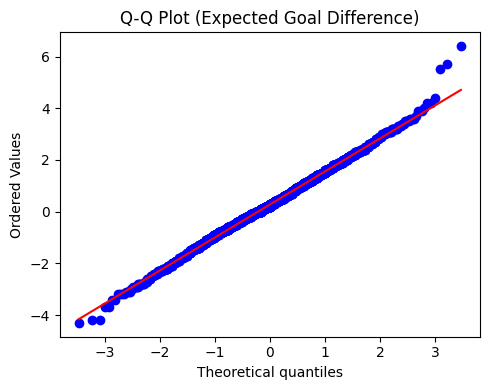

In [46]:
xg = xg_stats_df['diff_xg'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(xg, dist="norm", plot=plt)
plt.title("Q-Q Plot (Expected Goal Difference)")
plt.tight_layout()
plt.show()

In [47]:
t_stat, p_val = ttest_1samp(xg_stats_df['diff_xg'].dropna(), 0)
print(f"t-test for Diff_xG: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-test for Diff_xG: t-statistic = 11.148, p-value = 0.000


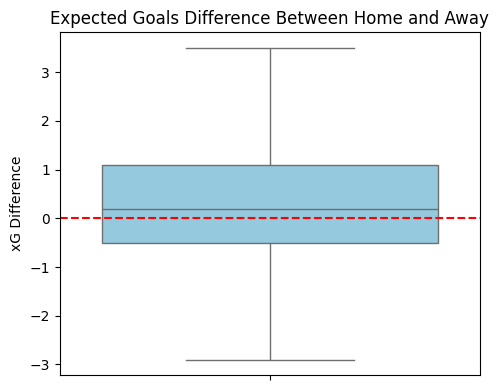

In [48]:
plt.figure(figsize=(5,4))
sns.boxplot(y=xg_stats_df['diff_xg'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Expected Goals Difference Between Home and Away")
plt.ylabel("xG Difference")
plt.tight_layout()
plt.show()

In [49]:
import statsmodels.formula.api as smf

xg_win = smf.logit("is_win ~ diff_xg", data=xg_stats_df).fit()
print(xg_win.summary())

margeff = xg_win.get_margeff()
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.547303
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 is_win   No. Observations:                 2660
Model:                          Logit   Df Residuals:                     2658
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.2042
Time:                        14:25:45   Log-Likelihood:                -1455.8
converged:                       True   LL-Null:                       -1829.4
Covariance Type:            nonrobust   LLR p-value:                1.627e-164
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5678      0.049    -11.704      0.000      -0.663      -0.473
diff_xg        1.0575      0.

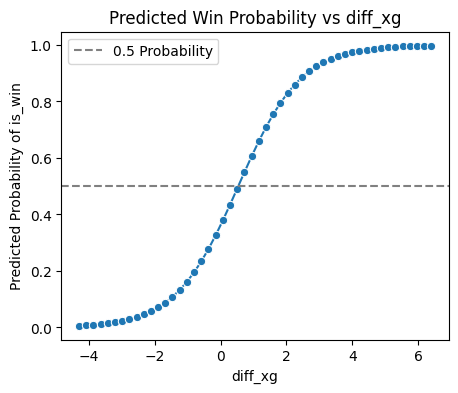

In [ ]:
diff_xg_range = np.linspace(xg_stats_df['diff_xg'].min(), xg_stats_df['diff_xg'].max())

df_pred = pd.DataFrame({'diff_xg': diff_xg_range})

df_pred['pred_prob'] = xg_win.predict(df_pred)

plt.figure(figsize=(5,4))
sns.lineplot(x='diff_xg', y='pred_prob', data=df_pred, marker="o")
plt.xlabel("diff_xg")
plt.ylabel("Predicted Probability of is_win")
plt.title("Predicted Win Probability vs diff_xg")
plt.axhline(0.5, color='gray', linestyle='--', label="0.5 Probability")
plt.legend()
plt.show()

In [50]:
# Computes per-referee statistics for expected goal difference (diff_xG),
# including the mean, standard deviation, and match count.
# It filters out referees with 5 or fewer matches, then sorts the results by average diff_xG in descending order.
ref_xg = (xg_stats_df.groupby('Referee')['diff_xg'].agg(['mean', 'std', 'count']).round(2))
ref_xg = ref_xg.rename(columns={'mean': 'avg_diff_xG', 'std': 'SD_Diff_xG', 'count': 'matches'})
ref_xg = ref_xg[ref_xg['matches'] > 5]
ref_xg = ref_xg.sort_values(by='avg_diff_xG', ascending=False)

print("Per-Referee Average Diff_xG (Only Referees with > 5 Matches):")
print(ref_xg.reset_index())

Per-Referee Average Diff_xG (Only Referees with > 5 Matches):
              Referee  avg_diff_xG  SD_Diff_xG  matches
0          Roger East         0.66        1.17       28
1          Mike Jones         0.64        1.02       12
2        Tim Robinson         0.63        1.15       24
3         Lee Probert         0.55        0.81       32
4         David Coote         0.49        1.12      106
5      Stuart Attwell         0.44        1.42      141
6       Robert Madley         0.44        1.17       20
7      Darren England         0.39        1.33       57
8        Simon Hooper         0.39        1.25      101
9     Tony Harrington         0.38        0.79       19
10       Peter Bankes         0.37        1.04       70
11       Graham Scott         0.36        1.34       93
12       Kevin Friend         0.36        1.39      116
13     Thomas Bramall         0.33        1.13       19
14          Mike Dean         0.32        1.35      132
15        John Brooks         0.31        

In [51]:
# pen_df = df.copy()

# pen_df = pen_df.dropna(subset=['Pkwon (penalty kicks won)'])

# clean_matched_pairs = []

# for (home_idx, away_idx) in matched_pairs:
#     if home_idx in pen_df.index and away_idx in pen_df.index:
#         clean_matched_pairs.append((home_idx, away_idx))

# print("Number of matched pairs after cleaning:", len(clean_matched_pairs))

Number of matched pairs after cleaning: 3040


In [52]:
# total_home_fld = 0
# total_home_cards = 0
# total_home_pen = 0
# total_away_fld = 0
# total_away_cards = 0
# total_away_pen = 0

# for (home_idx, away_idx) in clean_matched_pairs:
#   home_record = pen_df.loc[home_idx]
#   away_record = pen_df.loc[away_idx]

#   if home_record['Venue'] != 'Home':
#     home_record, away_record = away_record, home_record

#   referee = home_record['Referee']

#   home_cards = home_record['CrdY'] + home_record['2CrdY'] + home_record['CrdR']
#   away_cards = away_record['CrdY'] + away_record['2CrdY'] + away_record['CrdR']

#   home_fld = home_record['Fld (fouls drawn)']
#   away_fld = away_record['Fld (fouls drawn)']

#   home_pen = home_record['Pkwon (penalty kicks won)']
#   away_pen = away_record['Pkwon (penalty kicks won)']

#   total_home_fld += home_fld
#   total_home_cards += home_cards
#   total_home_pen += home_pen
#   total_away_fld += away_fld
#   total_away_cards += away_cards
#   total_away_pen += away_pen

# home_fld_pen = (total_home_fld / total_home_pen).round(2) if total_home_pen != 0 else np.nan
# home_crd_pen = (total_away_cards / total_home_pen).round(2) if total_home_pen != 0 else np.nan

# away_fld_pen = (total_away_fld / total_away_pen).round(2) if total_away_pen != 0 else np.nan
# away_crd_pen = (total_home_cards / total_away_pen).round(2) if total_away_pen != 0 else np.nan

# diff_fld_pen = home_fld_pen - away_fld_pen
# diff_crd_pen = home_crd_pen - away_crd_pen

# pen_stats_df = pd.DataFrame({
#     'Stats': ['Home - Away'],
#     'Diff_ratio (Cards per Penalty)': [diff_crd_pen],
#     'Diff_ratio (Fouls per Penalty)': [diff_fld_pen]
# })

# print(pen_stats_df)

         Stats  Diff_ratio (Cards per Penalty)  Diff_ratio (Fouls per Penalty)
0  Home - Away                            -2.8                          -23.83


In [53]:
# Merge referee-level statistics from three different sources:
# win rate differences, disciplinary metrics (cards, fouls, ratios), and expected goals (xG) differences into a single DataFrame.
# The merged DataFrame only retains relevant columns for home advantage analysis
home_adv_df = pd.merge(ref_stats, referee_diff, on="Referee", how="inner")
home_adv_df = pd.merge(home_adv_df, ref_xg, on='Referee', how='inner')
home_adv_df = home_adv_df.loc[:, ['Referee', 'diff_win_rate', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio', 'avg_diff_xG']]

print(home_adv_df.head())

          Referee  diff_win_rate  avg_diff_cards  avg_diff_fls  \
0    Tim Robinson           0.33           -0.75          1.08   
1  Thomas Bramall           0.31           -0.79         -2.21   
2      Roger East           0.29           -0.38         -0.76   
3    Robert Jones           0.26           -0.44          0.06   
4  Samuel Barrott           0.26           -0.40         -1.47   

   avg_diff_ratio  avg_diff_xG  
0            2.42         0.63  
1            0.25         0.33  
2            0.82         0.66  
3            1.29         0.21  
4            1.35         0.27  


In [56]:
# Calculate composite referee bias scores under the Home Advantage condition.
# Standardize selected metrics using z-scores.
# Assign custom weights to each metric based on their expected bias direction.
# Compute a weighted composite score and round it.
# Classify referees into biased/unbiased using the median composite score as threshold.
metrics = ['diff_win_rate', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio', 'avg_diff_xG']

for metric in metrics:
  home_adv_df[metric + '_z'] = (home_adv_df[metric] - home_adv_df[metric].mean()) / home_adv_df[metric].std()

weights = {
    'diff_win_rate_z': 1.5,
    'avg_diff_cards_z': -3,
    'avg_diff_fls_z': -1,
    'avg_diff_ratio_z': 3,
    'avg_diff_xG_z': 2
}

total_abs_weight = sum(abs(w) for w in weights.values())
home_adv_df['composite_bias'] = (
    weights['diff_win_rate_z'] * home_adv_df['diff_win_rate_z'] +
    weights['avg_diff_cards_z'] * home_adv_df['avg_diff_cards_z'] +
    weights['avg_diff_fls_z'] * home_adv_df['avg_diff_fls_z'] +
    weights['avg_diff_ratio_z'] * home_adv_df['avg_diff_ratio_z'] +
    weights['avg_diff_xG_z'] * home_adv_df['avg_diff_xG_z']
) / total_abs_weight

home_adv_df['composite_bias'] = home_adv_df['composite_bias'].round(2)
home_adv_df = home_adv_df.sort_values(by='composite_bias', ascending=False)

threshold = home_adv_df['composite_bias'].median()
home_adv_df['bias'] = (home_adv_df['composite_bias'] > threshold).astype(int)

print("Composite Bias Scores by Referee:")
print(home_adv_df[['Referee', 'composite_bias', 'bias']].sort_values(by='composite_bias', ascending=False).reset_index(drop=True))

Composite Bias Scores by Referee:
              Referee  composite_bias  bias
0        Tim Robinson            1.69     1
1      Darren England            1.14     1
2        Peter Bankes            1.04     1
3          Mike Jones            0.97     1
4      Thomas Bramall            0.91     1
5          Roger East            0.86     1
6      Samuel Barrott            0.66     1
7         Lee Probert            0.60     1
8        Simon Hooper            0.51     1
9        Robert Jones            0.42     1
10  Michael Salisbury            0.18     1
11    Tony Harrington            0.13     1
12     Stuart Attwell            0.03     1
13        David Coote           -0.12     1
14        Andy Madley           -0.13     1
15          Mike Dean           -0.16     0
16     Chris Kavanagh           -0.21     0
17       Graham Scott           -0.21     0
18      Jonathan Moss           -0.24     0
19      Robert Madley           -0.28     0
20          Lee Mason           -0.35     

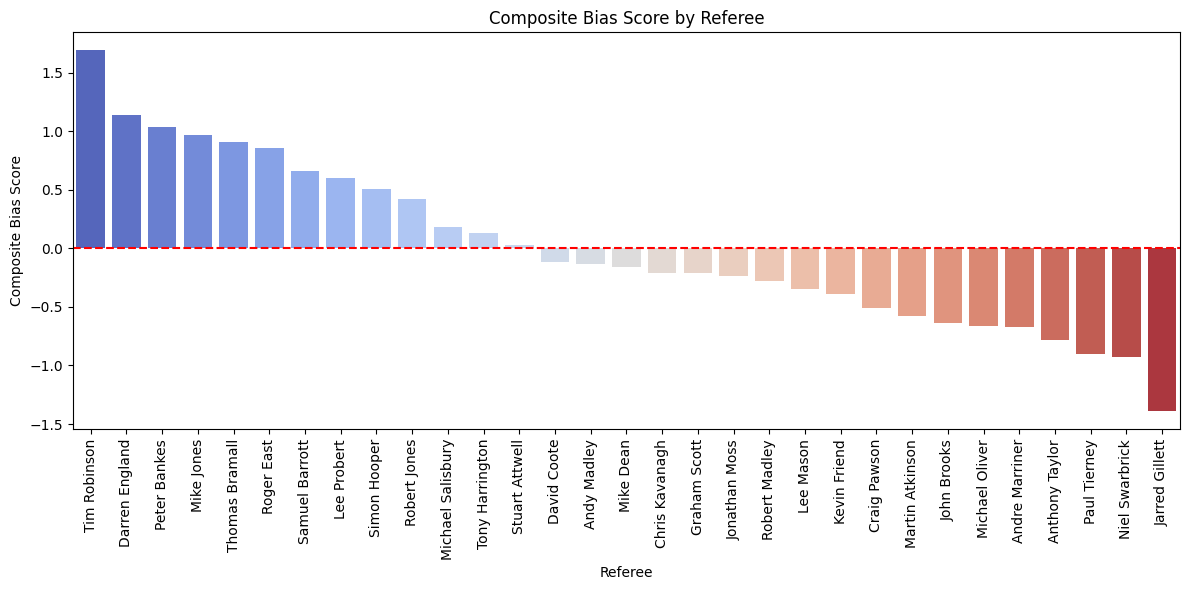

In [57]:
plt.figure(figsize=(12,6))
sns.barplot(x='Referee', y='composite_bias', data=home_adv_df, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Composite Bias Score")
plt.title("Composite Bias Score by Referee")
plt.tight_layout()
plt.show()